In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
data=pd.read_csv(r'/gdrive/MyDrive/Colab Notebooks/final_features-004.csv',encoding='latin-1')

In [4]:
data.head(5)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,38.575120,...,-14.608611,-14.153514,-29.568828,29.144799,41.087017,-6.711498,-8.812467,7.906522,-27.432420,10.599943,16.952886,-15.785523,-18.361750,-23.125756,-7.145598,-15.993189,-0.493609,3.726502,25.448065,16.128444,-27.806874,-2.436932,5.134369,-8.074996,24.421846,8.739254,-17.285154,13.440285,-13.209145,1.079919,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,-79.721632,...,-1.663620,-0.402938,-14.087219,38.538202,9.727834,13.917810,-22.559171,6.881677,-27.182516,23.088673,24.731105,11.367434,6.593838,-24.493328,-19.296450,-33.008435,-26.038134,24.669903,27.983948,1.638938,-24.155492,-9.086083,1.414648,8.240657,8.082218,16.568080,2.114171,1.494281,17.547449,-7.709981,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,52.444493,...,-8.954575,-15.803814,-5.150883,17.270690,14.479286,-8.041332,-37.765046,8.256755,-37.232596,0.989206,11.408972,-3.191425,-12.339837,-24.161270,-10.353968,-28.326909,-12.874845,6.732092,8.607652,0.745432,-25.891975,-9.892551,-6.407806,-1.322369,15.972339,17.672533,-9.950780,0.094202,-13.221513,-14.747519,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,-62.898284,...,-11.371908,-3.578342,-2.376237,20.909671,3.221330,-8.993710,-12.933957,0.584045,-15.961217,2.370193,9.618801,5.654456,-4.039893,-19.908457,-11.321396,-24.859472,-13.069850,9.953773,-1.694113,4.442514,-9.278886,-3.784161,8.152649,7.866912,8.705768,8.401290,-3.039061,10.259952,-8.754181,-7.158578,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,203.339632,...,-11.345449,6.101218,-23.438455,24.105925,10.318461,-0.063605,-1.480551,6.154874,-14.630949,19.905604,2.042963,-3.555425,-1.255108,-8.036084,-9.766769,-16.191164,-8.790663,4.519232,12.908963,10.736240,-24.625240,-19.771682,7.144672,8.497629,17.803612,5.478965,-10.447376,6.479129,-2.375045,-5.082603,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [5]:
data.shape

(404290, 797)

In [6]:
#creating subset of datapoints

data2=data.sample(n=100000,replace=False,random_state=11)

In [7]:
data2.shape

(100000, 797)

In [8]:
data2=data2.reset_index()

In [9]:
data2.head()

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,10499,10499,10499,0,0.999950,0.333328,0.000000,0.000000,0.399992,0.181817,0.0,0.0,6.0,8.0,76,59,56,80,0.694444,1,1,35,67,5,11,2.0,16.0,0.125000,2,0,84.964148,24.373026,14.636845,31.709426,-6.269959,56.482391,-77.429650,-11.789047,48.633772,52.566711,...,-12.992065,2.331154,-25.957412,22.839721,25.706683,-3.193114,-9.142611,-2.139377,-22.940598,27.009002,24.580325,-12.267225,16.734544,-31.817380,-0.327948,-20.902199,-10.858497,-6.968853,17.150215,11.189331,-31.083879,-10.038193,5.540197,4.994006,20.381855,-0.184870,-15.726515,-4.856504,-14.415669,8.482366,-21.190747,0.448474,26.381535,0.280995,5.868108,-10.933298,-14.567379,13.228097,26.136987,-7.433131
1,341040,341040,341040,0,0.857131,0.857131,0.999980,0.999980,0.916659,0.916659,0.0,1.0,0.0,12.0,95,91,92,92,0.901235,6,2,80,80,12,12,11.0,24.0,0.458333,8,4,22.540657,66.072132,32.609458,47.079858,40.776634,56.295457,-181.555651,-93.052680,83.382299,10.289629,...,-12.718213,-2.525291,-25.640018,24.370535,33.403762,-3.758386,-3.513511,7.975820,-30.344087,21.288133,21.320807,-11.596124,7.692616,-41.454730,-13.102214,-25.542223,-16.547850,23.439820,25.529160,-2.373762,-31.947998,-7.609550,10.301341,-5.178583,25.834027,14.758951,-8.167880,10.827970,-18.273025,-3.356522,0.089020,23.308548,10.778891,-10.348059,10.367833,-1.150285,-11.299193,4.648097,10.043321,-3.237573
2,6794,6794,6794,0,0.599988,0.374995,0.199996,0.166664,0.363633,0.307690,1.0,0.0,2.0,12.0,66,58,63,61,0.333333,1,1,74,62,13,11,4.0,24.0,0.166667,2,0,97.840857,19.103589,-28.916678,139.909883,2.797528,-13.373694,-90.226740,-43.764146,53.991155,28.770824,...,-17.851201,-8.672630,-23.844866,11.835250,23.935073,-2.414991,-16.880201,7.635062,-27.361493,3.000538,1.661059,-15.524406,-13.606686,-28.425332,-1.541609,-27.094175,-1.517412,15.407416,16.507962,8.695254,-28.332515,-2.947948,0.215372,-1.032286,34.235916,1.982888,-12.556174,-8.426154,-9.583151,-2.878645,7.108946,21.715830,-0.561009,-0.864291,15.731731,-0.304038,-19.830799,1.792075,3.258196,6.565624
3,106158,106158,106158,1,0.999983,0.499996,0.999950,0.333328,0.999988,0.421050,1.0,0.0,11.0,13.5,100,64,63,70,0.548387,1,2,130,61,18,8,7.0,26.0,0.269231,3,1,-185.313134,226.739194,243.799595,136.909888,-115.617316,181.107073,-135.146241,-201.207850,-22.062194,-110.942211,...,-1.565711,-14.518680,-4.720297,24.779262,19.157971,-20.578240,-22.142427,-13.545263,-14.271236,2.484982,10.889290,2.107522,0.465989,-10.889440,11.143448,-8.355894,-23.264603,18.212362,10.965151,-9.192754,12.254194,10.762364,15.776168,7.126570,10.384239,-9.232283,3.901317,4.024415,7.805169,6.403573,-23.694174,19.415143,9.357494,-8.194252,5.353447,-12.303939,-7.072272,-6.296045,16.507738,6.635410
4,233220,233220,233220,0,0.799984,0.799984,0.999980,0.499995,0.899991,0.599996,0.0,0.0,5.0,12.5,94,79,69,82,0.403509,5,5,56,76,10,15,8.0,25.0,0.320000,10,0,5.094069,10.961177,74.691710,80.137739,-1.415238,9.537018,3.734224,-37.804619,80.788843,17.822084,...,-15.166025,-3.395467,-22.208900,26.743147,10.476337,-14.916559,-31.467115,6.963636,-18.117740,-2.701717,12.052589,-5.815046,-19.032846,-13.977987,-8.524147,-34.517966,-21.844606,4.238725,9.322456,5.344241,-28.093718,-31.539011,-14.970836,4.156602,12.632527,13.438058,-16.155083,8.258825,-7.682032,-7.261052,14.156476,-4.042153,9.347927,-10.139625,11.035756,12.381889,-4.296079,19.192421,10.529180,8.899706


In [10]:
y_true = data2['is_duplicate']

In [11]:
data2.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [12]:
data2.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0.999950,0.333328,0.000000,0.000000,0.399992,0.181817,0.0,0.0,6.0,8.0,76,59,56,80,0.694444,1,1,35,67,5,11,2.0,16.0,0.125000,2,0,84.964148,24.373026,14.636845,31.709426,-6.269959,56.482391,-77.429650,-11.789047,48.633772,52.566711,83.835384,-1.424931,18.147410,1.484376,...,-12.992065,2.331154,-25.957412,22.839721,25.706683,-3.193114,-9.142611,-2.139377,-22.940598,27.009002,24.580325,-12.267225,16.734544,-31.817380,-0.327948,-20.902199,-10.858497,-6.968853,17.150215,11.189331,-31.083879,-10.038193,5.540197,4.994006,20.381855,-0.184870,-15.726515,-4.856504,-14.415669,8.482366,-21.190747,0.448474,26.381535,0.280995,5.868108,-10.933298,-14.567379,13.228097,26.136987,-7.433131
1,0.857131,0.857131,0.999980,0.999980,0.916659,0.916659,0.0,1.0,0.0,12.0,95,91,92,92,0.901235,6,2,80,80,12,12,11.0,24.0,0.458333,8,4,22.540657,66.072132,32.609458,47.079858,40.776634,56.295457,-181.555651,-93.052680,83.382299,10.289629,90.644702,-104.534273,43.856204,-5.663902,...,-12.718213,-2.525291,-25.640018,24.370535,33.403762,-3.758386,-3.513511,7.975820,-30.344087,21.288133,21.320807,-11.596124,7.692616,-41.454730,-13.102214,-25.542223,-16.547850,23.439820,25.529160,-2.373762,-31.947998,-7.609550,10.301341,-5.178583,25.834027,14.758951,-8.167880,10.827970,-18.273025,-3.356522,0.089020,23.308548,10.778891,-10.348059,10.367833,-1.150285,-11.299193,4.648097,10.043321,-3.237573
2,0.599988,0.374995,0.199996,0.166664,0.363633,0.307690,1.0,0.0,2.0,12.0,66,58,63,61,0.333333,1,1,74,62,13,11,4.0,24.0,0.166667,2,0,97.840857,19.103589,-28.916678,139.909883,2.797528,-13.373694,-90.226740,-43.764146,53.991155,28.770824,55.206009,-35.804775,65.674052,-27.785705,...,-17.851201,-8.672630,-23.844866,11.835250,23.935073,-2.414991,-16.880201,7.635062,-27.361493,3.000538,1.661059,-15.524406,-13.606686,-28.425332,-1.541609,-27.094175,-1.517412,15.407416,16.507962,8.695254,-28.332515,-2.947948,0.215372,-1.032286,34.235916,1.982888,-12.556174,-8.426154,-9.583151,-2.878645,7.108946,21.715830,-0.561009,-0.864291,15.731731,-0.304038,-19.830799,1.792075,3.258196,6.565624
3,0.999983,0.499996,0.999950,0.333328,0.999988,0.421050,1.0,0.0,11.0,13.5,100,64,63,70,0.548387,1,2,130,61,18,8,7.0,26.0,0.269231,3,1,-185.313134,226.739194,243.799595,136.909888,-115.617316,181.107073,-135.146241,-201.207850,-22.062194,-110.942211,-169.469588,73.211981,-205.105850,-175.965686,...,-1.565711,-14.518680,-4.720297,24.779262,19.157971,-20.578240,-22.142427,-13.545263,-14.271236,2.484982,10.889290,2.107522,0.465989,-10.889440,11.143448,-8.355894,-23.264603,18.212362,10.965151,-9.192754,12.254194,10.762364,15.776168,7.126570,10.384239,-9.232283,3.901317,4.024415,7.805169,6.403573,-23.694174,19.415143,9.357494,-8.194252,5.353447,-12.303939,-7.072272,-6.296045,16.507738,6.635410
4,0.799984,0.799984,0.999980,0.499995,0.899991,0.599996,0.0,0.0,5.0,12.5,94,79,69,82,0.403509,5,5,56,76,10,15,8.0,25.0,0.320000,10,0,5.094069,10.961177,74.691710,80.137739,-1.415238,9.537018,3.734224,-37.804619,80.788843,17.822084,-20.209214,10.928505,45.657573,27.493843,...,-15.166025,-3.395467,-22.208900,26.743147,10.476337,-14.916559,-31.467115,6.963636,-18.117740,-2.701717,12.052589,-5.815046,-19.032846,-13.977987,-8.524147,-34.517966,-21.844606,4.238725,9.322456,5.344241,-28.093718,-31.539011,-14.970836,4.156602,12.632527,13.438058,-16.155083,8.258825,-7.682032,-7.261052,14.156476,-4.042153,9.347927,-10.139625,11.035756,12.381889,-4.296079

### Splitting Data

In [13]:
import matplotlib.pyplot as plt
import re
import time
import warnings
from sklearn.preprocessing import normalize

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

- Stratification keeps distribution of class/strats as per orignal dataset. It doesnt create biased distribution of class in datapoints.


In [15]:
X_train,X_test, y_train, y_test = train_test_split(data2,y_true,stratify=y_true,test_size=0.3)

In [16]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30000, 794)


In [17]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train) #counting class labels
train_len = len(y_train)
print("Class 0: ",100*int(train_distr[0])/train_len,"Class 1: ", 100*int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",100*int(test_distr[1])/test_len, "Class 1: ",100*int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  63.05142857142857 Class 1:  36.94857142857143
---------- Distribution of output variable in train data ----------
Class 0:  36.946666666666665 Class 1:  36.946666666666665


In [18]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

- we need to generate 9 numbers and the sum of numbers should be 1 i.e those 9 numbers should be probablities of those 9 observations.

- one solution is to genarate 9 numbers and divide each of the numbers by their sum


Log loss on Test Data using Random Model 0.893517613064743


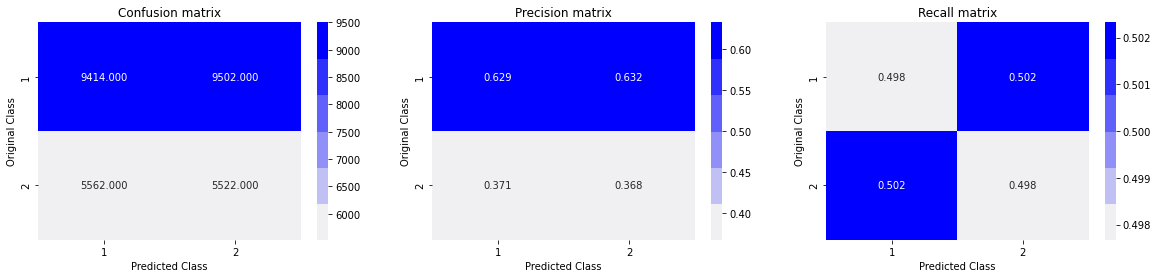

In [19]:
predicted_y = np.zeros((test_len,2)) #creating 2D vector of len = no of class labels in test_dataset
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0]) #pre_y[i]=rand_probs/np.sum(rand_probs,axis=1
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1) #find the index where the probability is higher row wise.
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [20]:
# alpha = [10**i for i in range(-2,2)]

# log_error_array=[]

# for i in alpha:

#   clf = SGDClassifier(alpha=i,loss='log',penalty='l2',random_state=42)
#   # clf.fit(X_train,y_train)
#   # print(clf.classes_)

#   #applying calibrated model on test data

#   sig_clf = CalibratedClassifierCV(base_estimator=clf,method='sigmoid',cv=3)
#   sig_clf.fit(X_train,y_train)

#   predict_y = sig_clf.predict_proba(X_test)
#   print(predicted_y)

#   #calculating Log error using log loss
#   log_error_array.append(log_loss(y_test,predicted_y))
#   print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))



In [21]:
# fig, ax = plt.subplots()
# ax.plot(alpha, log_error_array,c='g')
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()

# #after hypertuning we found best alpha value and training final model
# best_alpha = np.argmin(log_error_array) #finding index of aplha where log_loss is less
# clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
# clf.fit(X_train, y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(X_train, y_train)

# predict_y = sig_clf.predict_proba(X_train)
# print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
# predict_y = sig_clf.predict_proba(X_test)
# print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# #finding 
# predicted_y =np.argmax(predict_y,axis=1) 
# print("Total number of data points :", len(predicted_y))
# plot_confusion_matrix(y_test, predicted_y)

In [22]:
# #or you can plot classification report
# from sklearn.metrics import classification_report
# cr=classification_report(y_test,predicted_y)
# print(cr)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

In [23]:
# alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# # read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# # ------------------------------
# # default parameters
# # SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# # shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# # class_weight=None, warm_start=False, average=False, n_iter=None)

# # some of methods
# # fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# # predict(X)	Predict class labels for samples in X.

# #-------------------------------
# # video link: 
# #------------------------------


# log_error_array=[]
# for i in alpha:
#     clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
#     clf.fit(X_train, y_train)
#     sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
#     sig_clf.fit(X_train, y_train)
#     predict_y = sig_clf.predict_proba(X_test)
#     log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
#     print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# fig, ax = plt.subplots()
# ax.plot(alpha, log_error_array,c='g')
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()


# best_alpha = np.argmin(log_error_array)
# clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
# clf.fit(X_train, y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(X_train, y_train)

# predict_y = sig_clf.predict_proba(X_train)
# print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
# predict_y = sig_clf.predict_proba(X_test)
# print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
# predicted_y =np.argmax(predict_y,axis=1)
# print("Total number of data points :", len(predicted_y))
# plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [26]:
import xgboost as xgb

In [27]:
#creaying dictionary of parameters
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

In [28]:
#creating datasets compatible for Xgboost
d_train = xgb.DMatrix(X_train,label=y_train)
d_test = xgb.DMatrix(X_test,label=y_test)

In [29]:
watchlist = [(d_train, 'train'), (d_test, 'valid')]

In [32]:
#Training algorithm
bst = xgb.train(params, d_train, 30, watchlist, early_stopping_rounds=20, verbose_eval=10)


[0]	train-logloss:0.684891	valid-logloss:0.684928
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615233	valid-logloss:0.616152
[20]	train-logloss:0.564311	valid-logloss:0.565698
[29]	train-logloss:0.529228	valid-logloss:0.531015


In [33]:
xgdmat = xgb.DMatrix(X_train,y_train)

In [38]:
predict_y = bst.predict(d_test)
predict_y

array([0.68887424, 0.6810874 , 0.47899595, ..., 0.43488255, 0.27540156,
       0.68887424], dtype=float32)

In [40]:
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

The test log loss is: 0.5310114859173696


Total number of data points : 30000


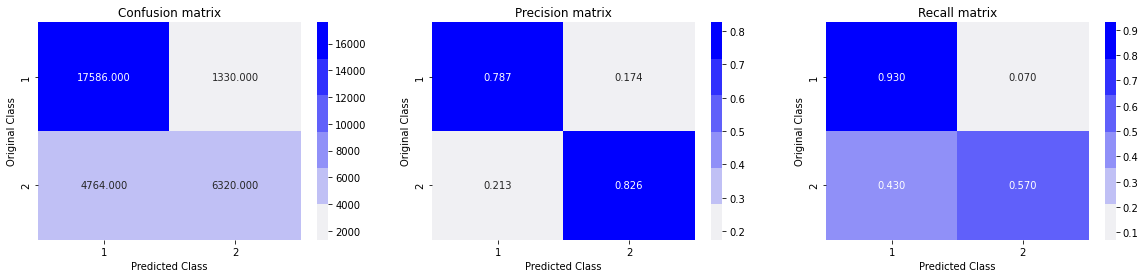

In [41]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)